<font color='red'>**MIT-BIH dataset**</font>


**Load Data**

In [1]:
import os
for dirname, _, filenames in os.walk('archive/mitbih_train.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", 

AttributeError: _ARRAY_API not found

In [3]:
train_df=pd.read_csv('archive/mitbih_train.csv',header=None)
test_df=pd.read_csv('archive/mitbih_test.csv',header=None)

**Balance of dataset**

In [4]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


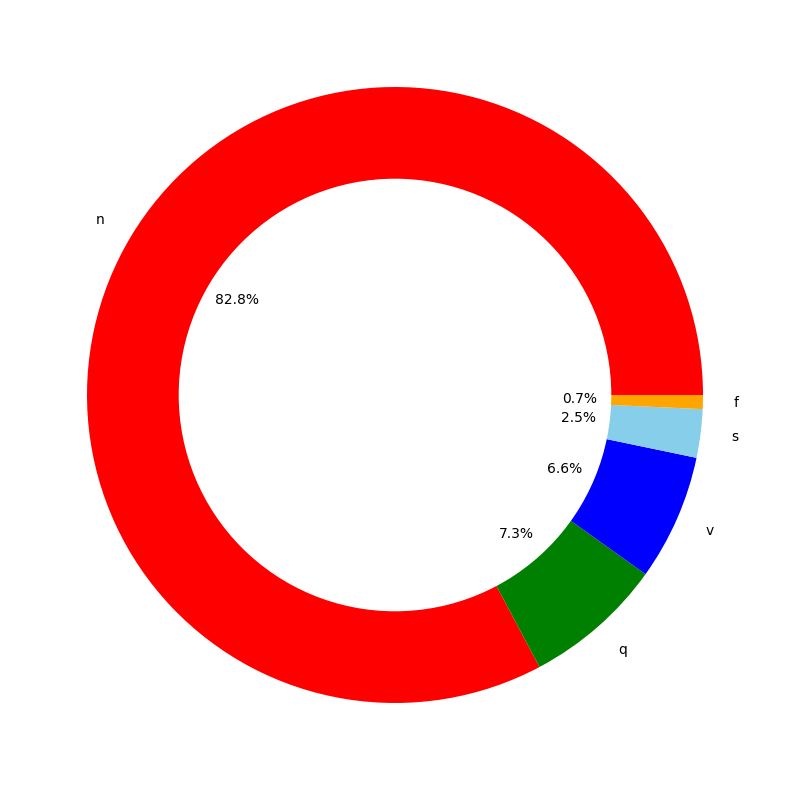

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
plt.savefig('data_ori.png')

In [6]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [7]:
equilibre=train_df[187].value_counts()
print(equilibre)


187
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64


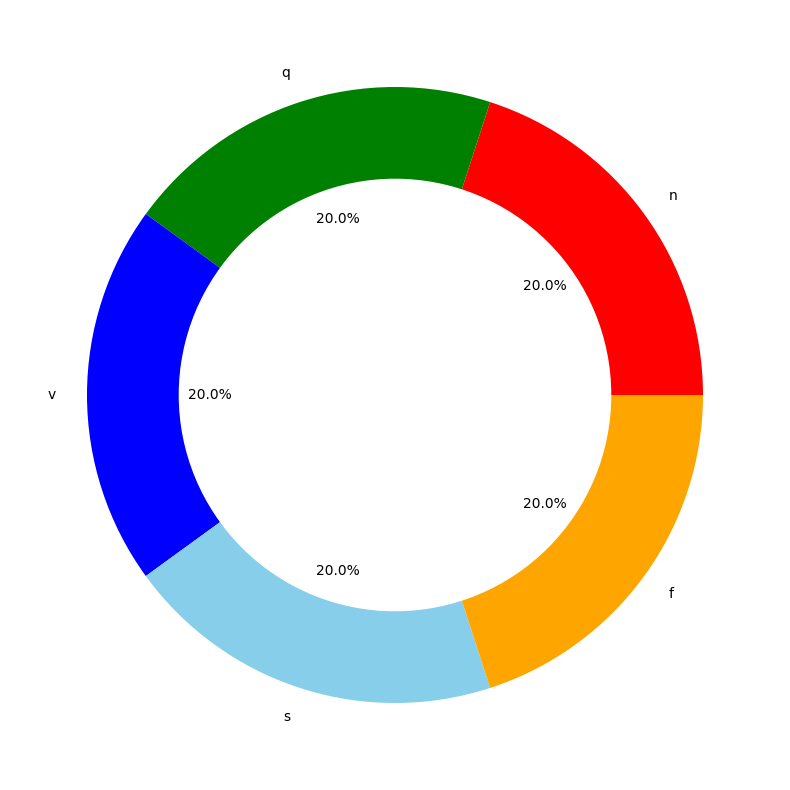

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
plt.savefig('data_balance.png')

**Pretreat**

Transform data. 

In [9]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)


Add a noise to the data to generilize my train.

In [10]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [11]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

**Network**

In [16]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=20,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.keras')
    return(model,history)

In [17]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [18]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, BatchNormalization
from keras.layers import Input
from keras.models import Model
#from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)



Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.6058 - loss: 1.0015 - val_accuracy: 0.5664 - val_loss: 1.1005
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.6961 - loss: 0.7979 - val_accuracy: 0.8143 - val_loss: 0.6395
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.7128 - loss: 0.7596 - val_accuracy: 0.6920 - val_loss: 0.7899
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.7222 - loss: 0.7335 - val_accuracy: 0.6429 - val_loss: 0.8414
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 71s 23ms/step - accuracy: 0.7353 - loss: 0.7004 - val_accuracy: 0.5247 - val_loss: 1.0658
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 71s 23ms/step - accuracy: 0.7421 - loss: 0.6782 - val_accuracy: 0.5980 - val_loss: 0.9287
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 70s 23ms/step - accuracy: 0.7548 - loss: 0.6489 - val_accuracy: 0.5783 - val_loss: 0.9568
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 70s 22ms/step - accuracy: 0.7658 -

Test Accuracy: 78.32%
Test Loss: 0.5863


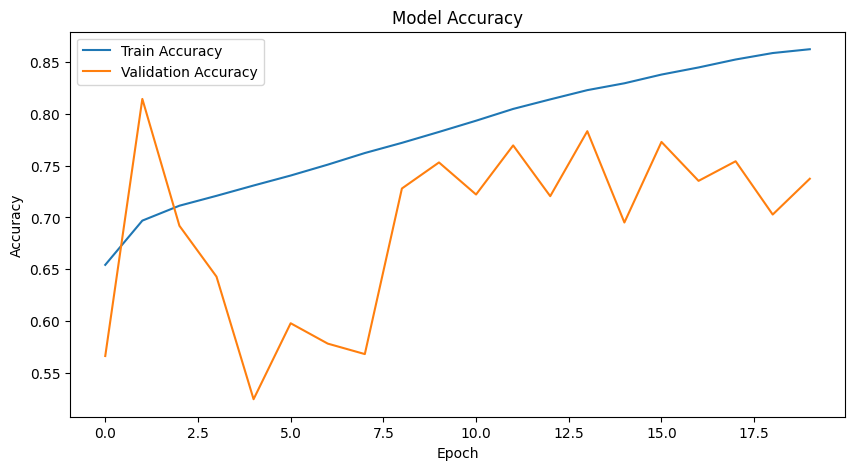

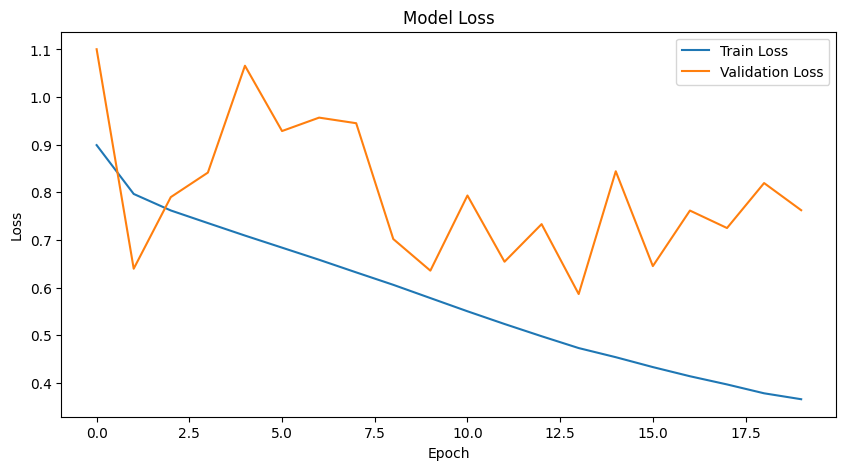

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           N       0.94      0.81      0.87     18118
           S       0.19      0.52      0.28       556
           V       0.46      0.52      0.49      1448
           F       0.09      0.81      0.16       162
           Q       0.79      0.84      0.81      1608

    accuracy                           0.78     21892
   macro avg       0.49      0.70      0.52     21892
weighted avg       0.87      0.78      0.82     21892

Normalized confusion matrix


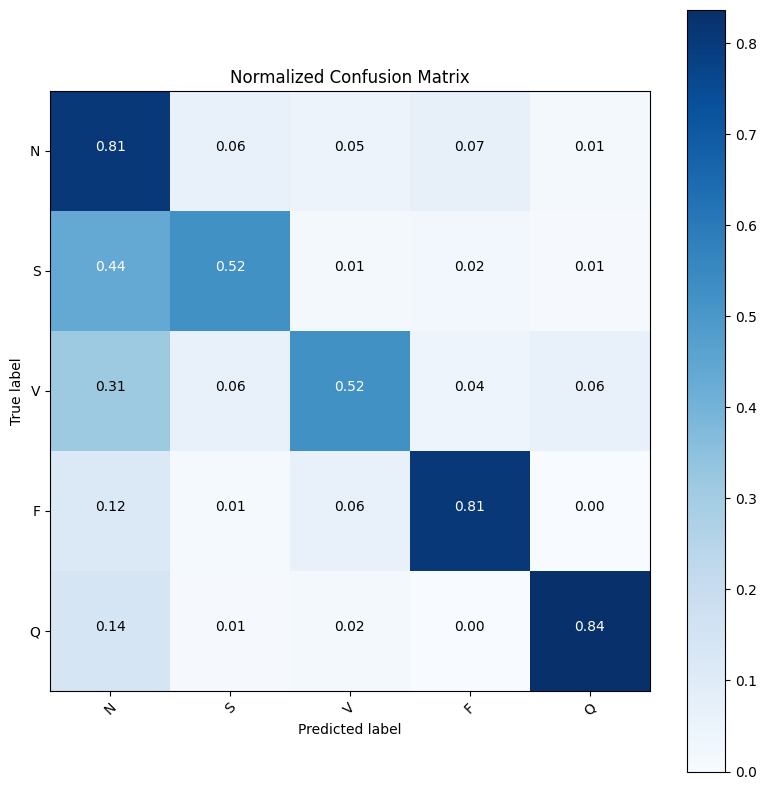

In [23]:
from sklearn.metrics import classification_report, accuracy_score
import itertools

def evaluate_model_with_metrics(history, X_test, y_test, model):
    # Evaluate model on test data
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Test Accuracy: {:.2f}%".format(scores[1] * 100))
    print("Test Loss: {:.4f}".format(scores[0]))

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

    # Compute predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['N', 'S', 'V', 'F', 'Q']))

    # Compute and plot confusion matrix
    def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
    cnf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'], normalize=True, 
                          title='Normalized Confusion Matrix')
    plt.show()

# Call the updated function after training
evaluate_model_with_metrics(history, X_test, y_test, model)
